# Determining Whether Amazon is Over/Underweight
*Chintan Vajariya* </p>

We begin this journey with a discussion of fundamental return weighting.

### Which security are we weighing?
Of the many stocks in the S&P 500, most will be overweight while some under. A stock like NVIDIA (NVDA) will quite easily qualify as overweight, while a non S&P stock such as Rite Aid (RA) would quite easily qualify as underweight. For this reason, I chose a large-cap stock, specifically **Amazon** (AMZN).

## Fundamental Returns Weighting

My first weighing technique will be defined by several *fundamental* datapoints, such as earnings per share (EPS), revenue, book value per share, fair value estimate, expected earnings etc. and its data will be scraped (with Selenium) from Yahoo Finance. Each of thse datapoints will be visually compared to the average values of the S&P, providing us with an easily digestible definition for weight.

In [78]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

stock_name = 'Amazon'
ticker = 'AMZN'

# url of NFLX Yahoo page
url = f'https://finance.yahoo.com/quote/{ticker}/key-statistics/?p={ticker}'

# initialize a web driver instance to control a Chrome window
options = Options()
options.add_argument('--headless=new')
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager(driver_version='119.0.6045.199').install()), options=options)

# visit the target page
driver.get(url)

# in order to find values, I use inspect element and select the value I want. then I right click on the element HTML
# and select "Copy XPath", which is pasted into the single quotes
# this scraping could be done for any stock

sp = driver.find_element(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/section[1]/div[2]/div[1]/section/div/section[1]/div[1]/fin-streamer[1]/span').text
if(sp != 'N/A'):
    stock_price = float(sp.replace(',', ''))

bvps = driver.find_element(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/div/section[1]/div/section[5]/table/tbody/tr[6]/td[2]').text
if(bvps != 'N/A'):
    book_val_per_share = float(bvps.replace(',', ''))

eps = driver.find_element(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/div/section[1]/div/section[4]/table/tbody/tr[7]/td[2]').text
if(eps != 'N/A'):
    earnings_per_share = float(eps.replace(',', ''))

per = driver.find_element(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/div/section[1]/div/section[5]/table/tbody/tr[5]/td[2]').text
if(per != 'N/A'):
    pe_ratio = float(per)

om = driver.find_element(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/div/section[1]/div/section[2]/table/tbody/tr[2]/td[2]').text
if(om != 'N/A'):
    operating_margin = float(om.replace('%', ''))

egr = driver.find_element(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/section[2]/div[2]/table[1]/tbody/tr[5]/td[2]').text
if(egr != 'N/A'):
    earnings_growth_rate = float(egr.replace('%', ''))

# since market cap and revenue are listed as '34.1B' or '821M', we need to convert them from strings into integers
tens = dict(k=10e3, m=10e6, b=10e9, t=10e12)
mc = driver.find_element(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/div/section[1]/div/section[4]/table/tbody/tr[1]/td[2]').text
if(mc != 'N/A'):
    market_cap = mc
factor, exp = market_cap[0:-1], market_cap[-1].lower()
market_cap = int(float(factor) * tens[exp])

ar = driver.find_element(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/div/section[1]/div/section[4]/table/tbody/tr[1]/td[2]').text
if(ar != 'N/A'):
    annual_revenue = ar
factor, exp = annual_revenue[0:-1], annual_revenue[-1].lower()
annual_revenue = int(float(factor) * tens[exp])

ps_ratio = market_cap / annual_revenue

pegr = driver.find_element(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/section[2]/div[2]/table[1]/tbody/tr[5]/td[2]').text
if(pegr != 'N/A'):
    peg_ratio = pegr

b = driver.find_element(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/div/section[2]/div/section[1]/table/tbody/tr[1]/td[2]').text
if(b != 'N/A'):
    beta = float(b)


# close the browser
driver.quit()

We've scraped all of the data that we'll need from Yahoo. Each of these datapoints can help us determine whether Netflix is overweight or underweight. However, we need to print this data and make a pandas dataframe out of it, which happens in this coming cell.

In [59]:
print("Stock Price: $" + str(stock_price))

# > stock price = better, overweight, S&P = 110.56
print("Book Value Per Share: $" + str(book_val_per_share))

# > is better, S&P average EPS last 12 months = 48.41
print("Earnings Per Share: $" + str(earnings_per_share))

#large price-earnings ratio = bad, S&P = 16.03
print("PE Ratio: " + str(pe_ratio))

# large = good, S&P average 16%
print("Operating Margin: " + str(operating_margin))

# large estimated growth rate = good, S&P average 0.8% over last 12 months
print("EGR: " + str(earnings_growth_rate))

# price sales ratio > S&P = good, S&P average PS last 12 months = 2.49
print("PS Ratio: " + str(ps_ratio))

# Price/Earnings-to-Growth ratio< 1 = good, S&P average  last 12 months = 1.56
print("PEG Ratio: " + str(peg_ratio))

# > 1 is volatile, S&P is 1, can be overweight depending on portfolio
print("Beta: " + str(beta))

Stock Price: $178.5
Book Value Per Share: $22.54
Earnings Per Share: $4.19
PE Ratio: 1.1
Operating Margin: 9.92
EGR: 2.16
PS Ratio: 1.0
PEG Ratio: 2.16
Beta: 1.15


## Data Visualization
Through this prior cell, we've scraped Yahoo's Statistics page on Amazon's and computed several values that will ultimately assist us in deciding whether the security is over or underweight. Our next step is to compare these values to the S&P average values, thereby informing us whether or not Amazon will outperform the market.

In [71]:
import pandas as pd
  
# initialize data of lists
test = {'Measurement': ["Stock Price =", "BVPS ↦", "EPS ↦", "PE Ratio ↤", "Operating Margin ↦", "EGR ↦", "PS Ratio ↦", "PEG Ratio ↤", "Beta ↦"],
        f'{stock_name}': [float(stock_price), float(book_val_per_share), float(earnings_per_share), float(pe_ratio), float(operating_margin), float(earnings_growth_rate), float(ps_ratio), float(peg_ratio), float(beta)], 
        'S&P 500': [5648.40, 1106.21, 47.37, 27.45, 11.5, 0.8, 2.98, 1.56, 1]}

df = pd.DataFrame(test)

# Print the output.
df

,Measurement,Amazon,S&P 500
0,Stock Price =,178.50,5648.40
1,BVPS ↦,22.54,1106.21
2,EPS ↦,4.19,47.37
3,PE Ratio ↤,1.10,27.45
4,Operating Margin ↦,9.92,11.50
5,EGR ↦,2.16,0.80
6,PS Ratio ↦,1.00,2.98
7,PEG Ratio ↤,2.16,1.56
8,Beta ↦,1.15,1.00


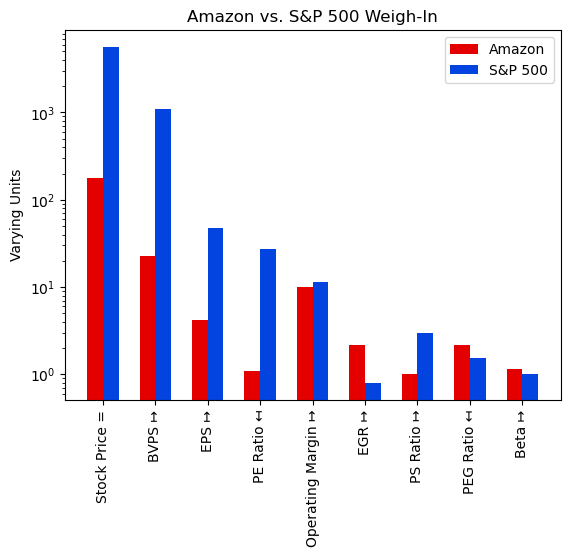

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# initialize a graph with no initialized inputs
fig, ax = plt.subplots()

# assigning the amount of x-points and width of bars
value = df['Measurement']
x = np.arange(len(value))
width = 0.3

# plotting each bar plot
ax.bar(x - width/2, df[f'{stock_name}'], width, label=f'{stock_name}', color='#e50000')
ax.bar(x + width/2, df['S&P 500'], width, label='S&P 500', color='#0343df')

# changing the yscale to logarithmic and assigning x-labels
ax.set_yscale('log')
ax.set_ylabel('Varying Units')
ax.set_title(f'{stock_name} vs. S&P 500 Weigh-In')
ax.set_xticks(x)
ax.set_xticklabels(value.astype(str).values, rotation='vertical')
ax.legend()

plt.show()

Each of these graphed values are indicitave of the weight of our Amazon stock. Those arrows on the value names inform you that the greater value has an increased weight. For example, for the PE Ratio, the higher number is "better"/has a greater weight, and the opposite is also true. The "=" implies that a greater value doesn't necessarily imply a weight. The reasons behind why these values are chosen are explained further in the write-up, but we find that Amazon is greater 2/8 times. By that definition, Netflix is an underweight stock, quite consistently. This makes sense. They've been quite stagnant since the pandemic, but their competition seems to just be going down. Temu (PDD) has only been going down over the last few months. If we did the same process for Apple, we'd see the following:

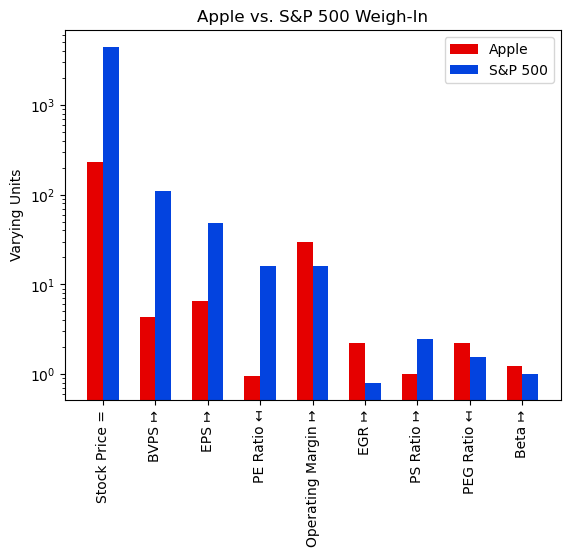

In [76]:
# these two are the only values I changed
stock_name = 'Apple'
ticker = 'AAPL'

url = f'https://finance.yahoo.com/quote/{ticker}/key-statistics?p={ticker}'

options = Options()
options.add_argument('--headless=new')
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager(driver_version='119.0.6045.199').install()), options=options)

driver.get(url)

sp = driver.find_element(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/section[1]/div[2]/div[1]/section/div/section[1]/div[1]/fin-streamer[1]/span').text
if(sp != 'N/A'):
    stock_price = float(sp.replace(',', ''))

bvps = driver.find_element(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/div/section[1]/div/section[5]/table/tbody/tr[6]/td[2]').text
if(bvps != 'N/A'):
    book_val_per_share = float(bvps.replace(',', ''))

eps = driver.find_element(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/div/section[1]/div/section[4]/table/tbody/tr[7]/td[2]').text
if(eps != 'N/A'):
    earnings_per_share = float(eps.replace(',', ''))

per = driver.find_element(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/div/section[1]/div/section[5]/table/tbody/tr[5]/td[2]').text
if(per != 'N/A'):
    pe_ratio = float(per)

om = driver.find_element(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/div/section[1]/div/section[2]/table/tbody/tr[2]/td[2]').text
if(om != 'N/A'):
    operating_margin = float(om.replace('%', ''))

egr = driver.find_element(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/section[2]/div[2]/table[1]/tbody/tr[5]/td[2]').text
if(egr != 'N/A'):
    earnings_growth_rate = float(egr.replace('%', ''))

# since market cap and revenue are listed as '34.1B' or '821M', we need to convert them from strings into integers
tens = dict(k=10e3, m=10e6, b=10e9, t=10e12)
mc = driver.find_element(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/div/section[1]/div/section[4]/table/tbody/tr[1]/td[2]').text
if(mc != 'N/A'):
    market_cap = mc
factor, exp = market_cap[0:-1], market_cap[-1].lower()
market_cap = int(float(factor) * tens[exp])

ar = driver.find_element(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/div/section[1]/div/section[4]/table/tbody/tr[1]/td[2]').text
if(ar != 'N/A'):
    annual_revenue = ar
factor, exp = annual_revenue[0:-1], annual_revenue[-1].lower()
annual_revenue = int(float(factor) * tens[exp])

ps_ratio = market_cap / annual_revenue

pegr = driver.find_element(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/section[2]/div[2]/table[1]/tbody/tr[5]/td[2]').text
if(pegr != 'N/A'):
    peg_ratio = pegr

b = driver.find_element(By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/article/div/section[2]/div/section[1]/table/tbody/tr[1]/td[2]').text
if(b != 'N/A'):
    beta = float(b)


# close the browser
driver.quit()

  
test = {'Measurement': ["Stock Price =", "BVPS ↦", "EPS ↦", "PE Ratio ↤", "Operating Margin ↦", "EGR ↦", "PS Ratio ↦", "PEG Ratio ↤", "Beta ↦"],
        f'{stock_name}': [float(stock_price), float(book_val_per_share), float(earnings_per_share), float(pe_ratio), float(operating_margin), float(earnings_growth_rate), float(ps_ratio), float(peg_ratio), float(beta)], 
        'S&P 500': [4450.32, 110.56, 48.41, 16.03, 16, 0.8, 2.49, 1.56, 1]}

df = pd.DataFrame(test)

fig, ax = plt.subplots()

value = df['Measurement']
x = np.arange(len(value))
width = 0.3

ax.bar(x - width/2, df[f'{stock_name}'], width, label=f'{stock_name}', color='#e50000')
ax.bar(x + width/2, df['S&P 500'], width, label='S&P 500', color='#0343df')

ax.set_yscale('log')
ax.set_ylabel('Varying Units')
ax.set_title(f'{stock_name} vs. S&P 500 Weigh-In')
ax.set_xticks(x)
ax.set_xticklabels(value.astype(str).values, rotation='vertical')
ax.legend()

plt.show()

From our valuation, Apple is neither over- nor under-weight, bringing us some justification for its astonishing market cap. They pass 4/8 of our tests, providing a more neutral rating when compared to Amazon.